# **Academic Achievement Gaps by Race: How Much Are Economic Differences to Blame?**
by Ishan Datta

# Project 1

## Introduction

When it comes to academic achievement, especially when measured by test scores, two major concerns arise in discussions of education inequality: discrepancies by race, and discrepancies by wealth. One study in particular - Dixon-RomÁN et. al (2013) - examined the relationship between race, income, and academic performance on the U.S.'s standardized Scholastic Aptitude Test (SAT). They found, somewhat unsurprisingly, a positive relationship between income and SAT performance. But there was also a gap between white and black student performance at every income level.

There are a lot of interpretations on where that racial disparity comes from, with many researchers identify sociocultural contexts to race that correlate with academic outcomes. Osborne (1997) observes a sense of "academic disidentification" that is seen as a response to negative racial stereotypes, while Carter (2016) explores a case study recognizing social dynamics within school creating race-based academic disparities, even with similar socioeconomic backgrounds. Farkas (2004) argues that differences in academic inclination emerge due to differences in how black and white kids are raised before entering school.

Students' socioeconomic advantages may have can be broadly divided into two categories: advantages from school, and advantages from home. Both types of advantages conceivably could influence academic performance, but the relationship between these two types of advantages adds another layer of nuance. Wodtke et. al (2023) suggests that these two types of advantages don't meaningfully overlap, so it may be meaningful to conduct analysis with both types of factors.

For this project, I use data for the 2018-2019 school year. I use the National Center for Education Statistics (NCES) Public Schools Characteristics 2018-19 dataset as my primary catalog of U.S. public schools. My supplementary datasets are the District Costs Database (DCD) 2024 and the American Community Survey (ACS) 2019 data 5-Year Estimate S1901 dataset.

## Data Loading and Cleaning

Using the datasets mentioned in the introduction, we select variables to use in our analysis.

Our main independent "X" variable is race - more specifically, racial distributions by school, which, at this point in our research, we denote with the percentage of students that are white, since most literature revolves around white vs. non-white students. Our main dependent "Y" variable will be academic achievement, measured in terms of standard deviations away from to the national average.

Our other "X" variables fall into two broad categories: school factors and personal factors.

School factors include all those factors that affect the quality of school, and by extension the quality of their students' education. To account for these, we use student-to-teacher ratio; whether the school gets Title I assisstance or not (i.e. getting resources to assist low income households and the like); whether the school is a charter school or not; and district spending per student. For district spending, we use two measures: absolute and relative cost. The distinction is that the DCD 2024 dataset includes predictions about the necessary spending per student, which creates a funding gap relative to the absolute amount of funding per student.

Student factors are those from the student or from their families which potentially affect their education. For this, we have median family income and the percentage of English Language Learners (ELL) in the district. 

Location also plays a factor, but that will be examined later on.


In [230]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importing data for 2019 analysis

# Public School Characteristics for the 2018-19 school year
psc19 = pd.read_csv(r"Data/2018-2019/Public_School_Characteristics_2018-19.csv")

# District Cost Database 2024
dcd = pd.read_csv(r"Data\DistrictCostDatabase_2024.csv")

# American Community Survey Data 2019
acs19 = pd.read_csv(r"Data\2018-2019\ACS 2019\ACSST5Y2019.S1901-Data.csv")

C:\Users\idatt\AppData\Local\Temp\ipykernel_12432\852147228.py:15: DtypeWarning: Columns (2,3,34,35,66,67,98,99) have mixed types. Specify dtype option on import or set low_memory=False.
  acs19 = pd.read_csv(r"Data\2018-2019\ACS 2019\ACSST5Y2019.S1901-Data.csv")


In [231]:
# Filtering out irrelevant columns and rows
psc19 = psc19.drop(['X', 'Y', 'OBJECTID', 'SURVYEAR', 'ST_LEAID', 'SCH_NAME', 'LSTREET1', 'LSTREET2', 'LZIP4', 'PHONE', 'MAGNET_TEXT', 'VIRTUAL', 'TOTMENROL', 'TOTFENROL'], axis=1)
ok_status = [1, 3, 5, 8]
psc19 = psc19[psc19['STATUS'].isin(ok_status)]

acs19 = acs19[['NAME', 'S1901_C02_012E', 'S1901_C02_013E']]

dcd19 = dcd[dcd['year'] == 2019]
dcd19 = dcd19.drop(['year', 'district', 'state_name', 'stabbr'], axis=1)
dcd19 = dcd19[list(dcd19.columns[0:5]) + list(dcd19.columns[6:7]) + list(dcd19.columns[8:9])]

We then clean the data, removing and filling in incomplete data points. These processes removed a few thousand points, which may hinder further analysis, but the datasets are largely still intact.

In [233]:
# cleaning incomplete data

# cleaning PSC19
psc_vals_to_rm = [-1, -2, -9, 'M', 'N'] # denotes that values are missing / data is incomplete
psc19 = psc19[~psc19.isin(psc_vals_to_rm).any(axis=1)]

# fill in grade school and race gaps
grades = list(psc19.columns[21:38]) # ['PK', 'KG', 'G01', 'G02', ..., 'G13', 'UG', 'AE']
races = list(psc19.columns[42:63])
psc19[grades] = psc19[grades].fillna(0)
psc19[races] = psc19[races].fillna(0)

psc19['STUTERATIO'] = np.where(
    psc19['TOTAL'].notna() & psc19['FTE'].notna(),  # Condition: both columns are non-missing
    psc19['TOTAL'] / psc19['FTE'],                 # Calculate ratio if condition is True
    psc19['STUTERATIO']                      # Keep original value if condition is False
)
psc19 = psc19.dropna()

# cleaning DCD19
dcd19 = dcd19.dropna()

# cleaning ASC19
acs19 = acs19.drop(0)
acs19 = acs19[~acs19.apply(lambda row: '-' in row.values, axis=1)]
acs19['NAME'] = acs19['NAME'].str.extract(r'(\d{5})')


We can merge the datasets. The DCD19 data is matched to schools by district, while the ACS19 data is matched to schools by ZIP code.

In [235]:
# merge DCD19
dcd19.rename(columns={'leaid': 'LEAID'}, inplace=True)

df19 = psc19.merge(dcd19, on="LEAID", how = 'inner')

# merge ACS19

acs19.rename(columns={'NAME': 'LZIP'}, inplace=True)
type(acs19['LZIP'])
acs19['LZIP'] = pd.to_numeric(acs19['LZIP'])
df19 = df19.merge(acs19, on="LZIP", how = 'inner')

Finally, we add and remove some columns to clean things up.

In [237]:
df19['white_%'] = df19['WH'] / df19['TOTAL']
df19 = df19.drop(['NCESSCH', 'TITLEI', 'STATUS', 'SY_STATUS_TEXT', 'ULOCALE', 'FRELCH', 'REDLCH', 'MEMBER', 'pov', 'S1901_C02_013E'], axis = 1)

df19['is_rich'] = df19['S1901_C02_012E'] == '250,000+'
df19 = df19[~df19['is_rich']]
df19['S1901_C02_012E'] = df19['S1901_C02_012E'].astype(int)

TE_RATIO = df19[['TOTAL', 'FTE', 'STUTERATIO']]
TE_RATIO = TE_RATIO[(TE_RATIO['FTE'] != 0)]
TE_RATIO = TE_RATIO[(TE_RATIO['TOTAL'] != 0)]

frlch = df19[['TOTFRL', 'TOTAL']]
frlch = frlch[frlch['TOTAL'] != 0]
frlch['FRLCH_%'] = frlch['TOTFRL'] / frlch['TOTAL']

df19.rename(columns={'S1901_C02_012E': 'family_income'}, inplace=True)

## Summary Statistics

Now that all our data is merged into one dataset, we can easily pull out summary statistics.

We can then summarize our measures of academic achievement.

In [240]:
df19[['TOTFRL', 'fundinggap', 'outcomegap', 'ell', 'family_income', 'white_%']].describe()

,TOTFRL,fundinggap,outcomegap,ell,family_income,white_%
count,67491.000000,67491.000000,67491.000000,67491.000000,67491.000000,67401.000000
mean,292.674860,-829.478123,-0.023797,0.093632,78639.468181,0.517864
std,270.194647,6433.441631,0.353322,0.100335,30466.887384,0.323419
min,0.000000,-63056.000000,-1.944165,0.000000,10170.000000,0.000000
25%,109.000000,-3722.000000,-0.269845,0.017592,58035.000000,0.209607
50%,225.000000,-241.000000,-0.014184,0.057947,72083.000000,0.565217
75%,396.000000,2807.000000,0.198216,0.145089,92538.000000,0.818336
max,4407.000000,45914.000000,1.583607,0.761042,249931.000000,1.000000


This table aggregates the summary statistics for the main variables in our dataset. The mean white % is around 51% - which is significantly lower than the national average. There might be some systematic reason for schools having lower white populations on average - potentially relating to fertility rates by race - but that is beyond the scope of this paper. Family income averages almost 79000, which is about on par with the median household income of 75000-80000 per year. Interestingly, it seems like the average US student is slightly underfunded, though there is a lot of variation around this mean. There is also a significant number of students recieving free or reduced lunch per school, which may act as a potential counterweight to family income and be correlated with school spending.

## Plots, Histograms, and Figures

Below are some visualizations using the data we have.

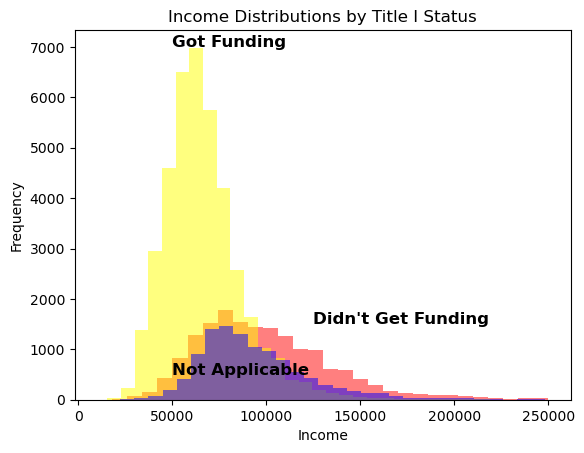

In [254]:
# Title I vs. Income Data

funded = df19[df19['STITLEI'] == '1-Yes']['family_income']
unfunded = df19[df19['STITLEI'] == '2-No']['family_income']
non_applic = df19[df19['STITLEI'] == 'Not Applicable']['family_income']

# Create histograms
plt.hist(non_applic, bins=30, alpha=0.5, label='Non Applicable', color='red')
plt.hist(funded, bins=30, alpha=0.5, label='Got Funding', color='yellow')
plt.hist(unfunded, bins=30, alpha=0.5, label='Didn\'t Get Funding', color='blue')


# Add labels and Text
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.title('Income Distributions by Title I Status')

plt.text(50000, 7000, 'Got Funding', color='black', fontsize=12, fontweight='bold')
plt.text(125000, 1500, 'Didn\'t Get Funding', color='black', fontsize=12, fontweight='bold')
plt.text(50000, 500, 'Not Applicable', color='black', fontsize=12, fontweight='bold')

plt.show()

The three histograms above represent the three different distributions of income between schools that got Title I funding, those that could have but didn't, and those where the question of Title I funding was not applicable. A quick look at the graph suggests that the median family income of those schools that got Title I funding were a fair bit lower than the other schools. An interesting note, however, is that the distributions for schools that didn't get funding, and schools were Title I funding was not applicble, look very similar, save for the differences in sample size. This seems to suggest that the areas where Title I is going to are places where people make overall less money, meaining the program is doing its job correctly.

In [257]:
# Scatter Plot of Absolute Funding vs. Predicted Cost

plt.plot(df19['fundinggap'], df19['outcomegap'], color='blue', linestyle='', marker='o')
plt.xlabel('Funding Gap (Per Student)')
plt.ylabel('Academic Outcomes (vs. National Average)')
plt.title('The funding gap and academic outcomes')

Text(0.5, 1.0, 'The funding gap and academic outcomes')

This graph displays the difference in the absolute cost per student and the predicted cost per student, and relates that to the academic achievement of students relative to the national average. This graph is quite interesting because, for the most part, the scatterplot shows a linear relationship between the funding gap and academic outcomes - as funding for students relative to their needs increases, so does their academic performance. The graph is also centered around (0,0), which is expected. However, there is a curious trend where there are a significant number of schools that are very underfunded (by $20,000 or more per student), and while their academic outcomes are below average, they do not follow the same sharp linear relationship seen in the majority of the scatterplot. This shows that there must be extraneous factors that the cost model used has not picked up on, as in principle, the cost model should show a direct relationship between the funding gap and academic performance.

C:\Users\idatt\AppData\Local\Temp\ipykernel_12432\1959454088.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="white_deciles", y="outcomegap", data=df19, palette="muted")


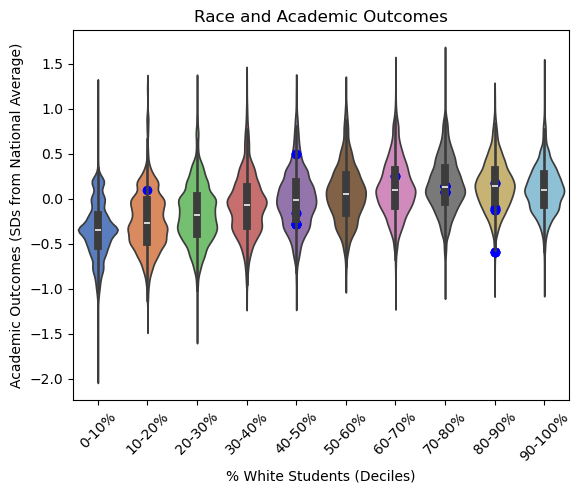

In [260]:
# Race vs. Academic Outcomes

# Convert 'variable' into deciles
df19['white_deciles'] = pd.qcut(df19['white_%'], q=10, labels=[f"{i*10}-{(i+1)*10}%" for i in range(10)])

# Creating a violin plot
sns.violinplot(x="white_deciles", y="outcomegap", data=df19, palette="muted")

# Adding labels and title
plt.title("Race and Academic Outcomes")
plt.xlabel("% White Students (Deciles)")
plt.xticks(rotation=45)
plt.ylabel("Academic Outcomes (SDs from National Average)")

# Display the plot
plt.show()

This violin plot above centers around the core problem of the research project: Race vs. Academic Performance. This visualization corroborates previous work in the area showing that there is a positive association between race and academic outcomes. However, an interesting note is that while the relationship seems mostly linear, the positive relation between white percentage and academic performance seems to plateau, and even decrease a little bit, at higher end of the white distribution. While a linear model would still fit this data well, we may require some extra adjustments to optimize a linear model.

# Project 2
## The Message

On the whole, economic factors do not seem to adequetely account for academic disparities by race. The split between the effect of economic factors and other factors seems to be roughly 50-50.

## Maps

Below are a few maps using the cleaned data.

In [265]:
!pip install -q linearmodels

# import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from linearmodels.iv import IV2SLS

df19.rename(columns={'S1901_C02_012E': 'family_income'}, inplace=True)

In [266]:
import geopandas as gpd
from scipy.interpolate import griddata
from shapely.geometry import Point

In [267]:
correlations = {}

for county, group in df19.groupby("NMCNTY"):
    corr = group["fundinggap"].corr(group["family_income"])  # Calculate correlation
    correlations[county] = corr

# Convert results to a DataFrame
correlation_df19 = pd.DataFrame(list(correlations.items()), columns=["NMCNTY", "Correlation"])
county_shape19 = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2019/COUNTY/tl_2019_us_county.zip")
# List of mainland state FIPS codes
mainland_state_fips = [
    '01', '04', '05', '06', '08', '09', '10', '11', '12', '13', '16',
    '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27',
    '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38',
    '39', '40', '41', '42', '44', '45', '46', '47', '48', '49', '50',
    '51', '53', '54', '55', '56'
]

# Filter counties by state FIPS codes
county_shape19 = county_shape19[county_shape19['STATEFP'].isin(mainland_state_fips)]
# correlation_df19 = correlation_df19.merge(df19, on='NMCNTY', how='inner')

C:\Users\idatt\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\idatt\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\idatt\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\idatt\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\idatt\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [268]:
county_shape19.rename(columns={'NAMELSAD': 'NMCNTY'}, inplace=True)

combined19 = county_shape19.merge(correlation_df19, on='NMCNTY', how="inner")
combined19 = combined19.drop(['CSAFP', 'CBSAFP', 'METDIVFP'], axis=1)
combined19.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NMCNTY', 'LSAD',
       'CLASSFP', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT',
       'INTPTLON', 'geometry', 'Correlation'],
      dtype='object')

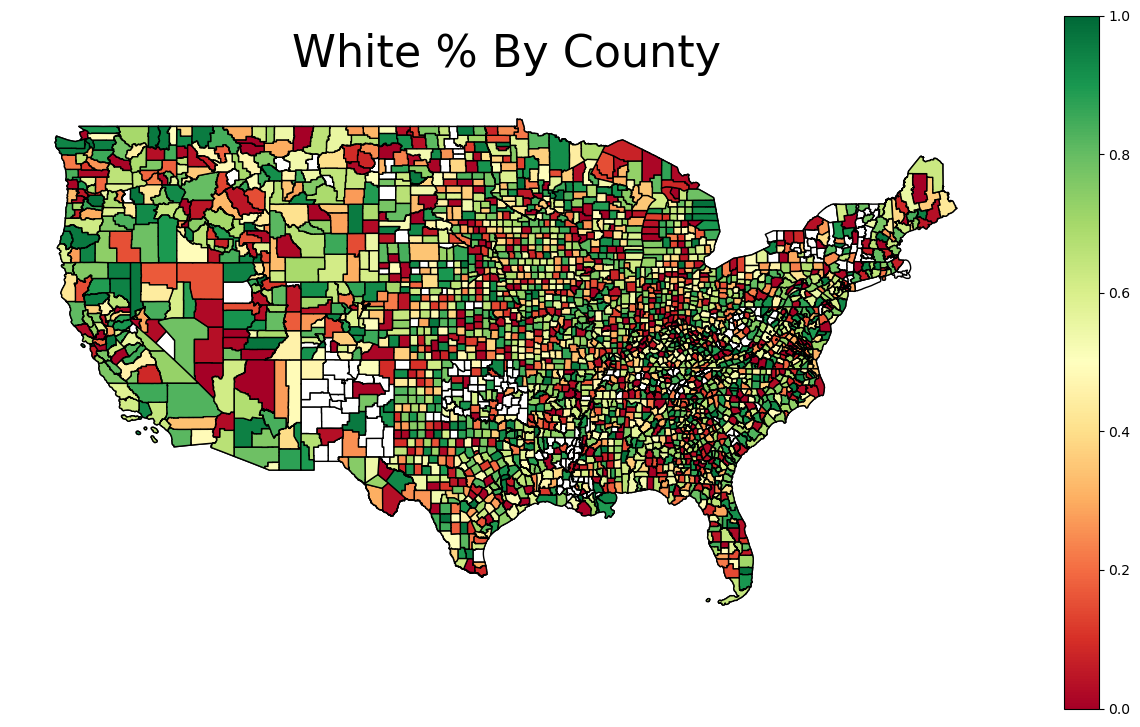

In [269]:
combined19['white_%'] = df19['white_%']

fig, gax = plt.subplots(figsize = (16,9))

# Plot the state
county_shape19.plot(ax = gax, edgecolor='black',color='white')
combined19.plot(ax = gax, edgecolor='black', column='white_%', legend=True, cmap='RdYlGn', vmin = 0, vmax=1)

# I don't want the axis with long and lat
plt.axis('off')

gax.set_title('White % By County', fontsize=32, color='black', pad=20)

plt.show()

This map, as the title suggests, shows the distribution of white people across the country, in particular measuring the percent of students in each county that are white. One thing that stands out is the relatively even distribution of more white and less white counties geographically across the state.  There are some places where there is a clustering of low-white counties, especially the Midwest, but most places seem to have a decent mix of high-white and low-white counties. This is quite nice, since it's unlikely there will be a major systemic bias for or against a particular state/region when relating race, academic performance and other factors.

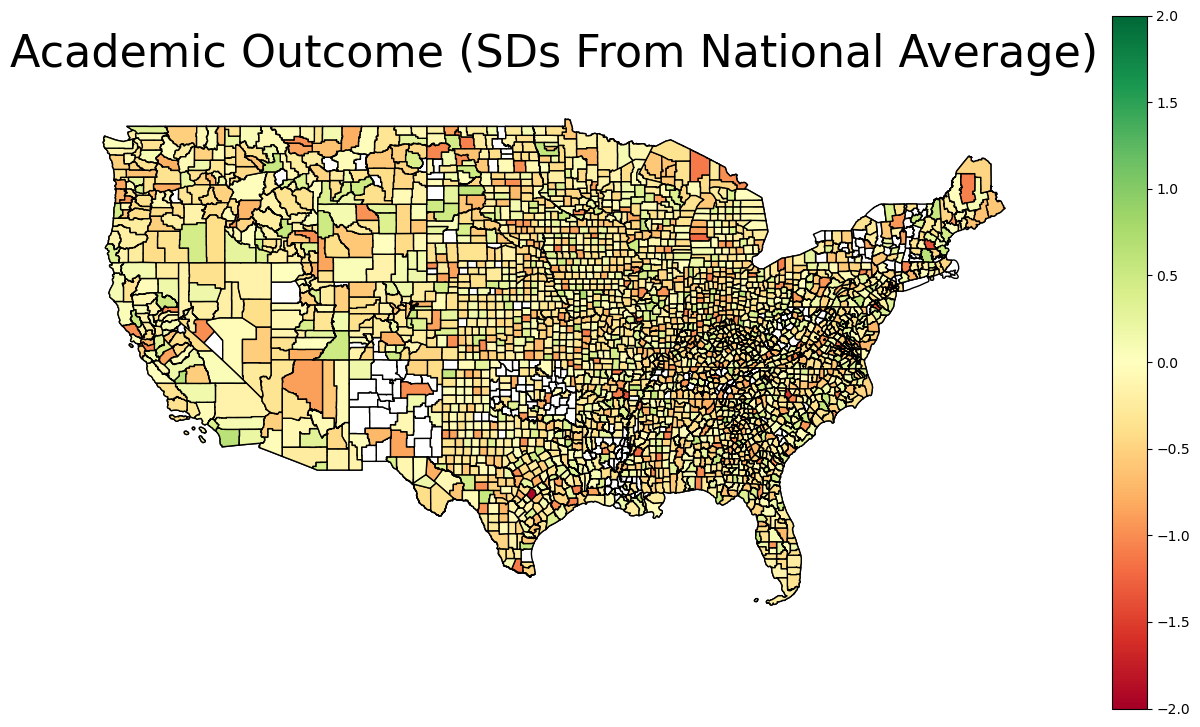

In [271]:
combined19['outcomegap'] = df19['outcomegap']

fig, gax = plt.subplots(figsize = (16,9))

# Plot the state
county_shape19.plot(ax = gax, edgecolor='black',color='white')
combined19.plot(ax = gax, edgecolor='black', column='outcomegap', legend=True, cmap='RdYlGn', vmin = -2, vmax=2)

# I don't want the axis with long and lat
plt.axis('off')

gax.set_title('Academic Outcome (SDs From National Average)', fontsize=32, color='black', pad=20)

plt.show()

The map shown above measures academic performance in each county, scaled to the number of standard deviations below or above the US national academic average. The scaling from -2 to 2 is to account for the majority of schools being within 2 standard deviations of the national average. One interesting thing to note is that there seem to be more below-average counties overall than above average counties. Said above average counties don't seem to have any immediate patterns in terms of their location, but this suggests that the counties with above average performance may contain more people overall than below-average counties, hinting at potential trends in population density / infrastructure.

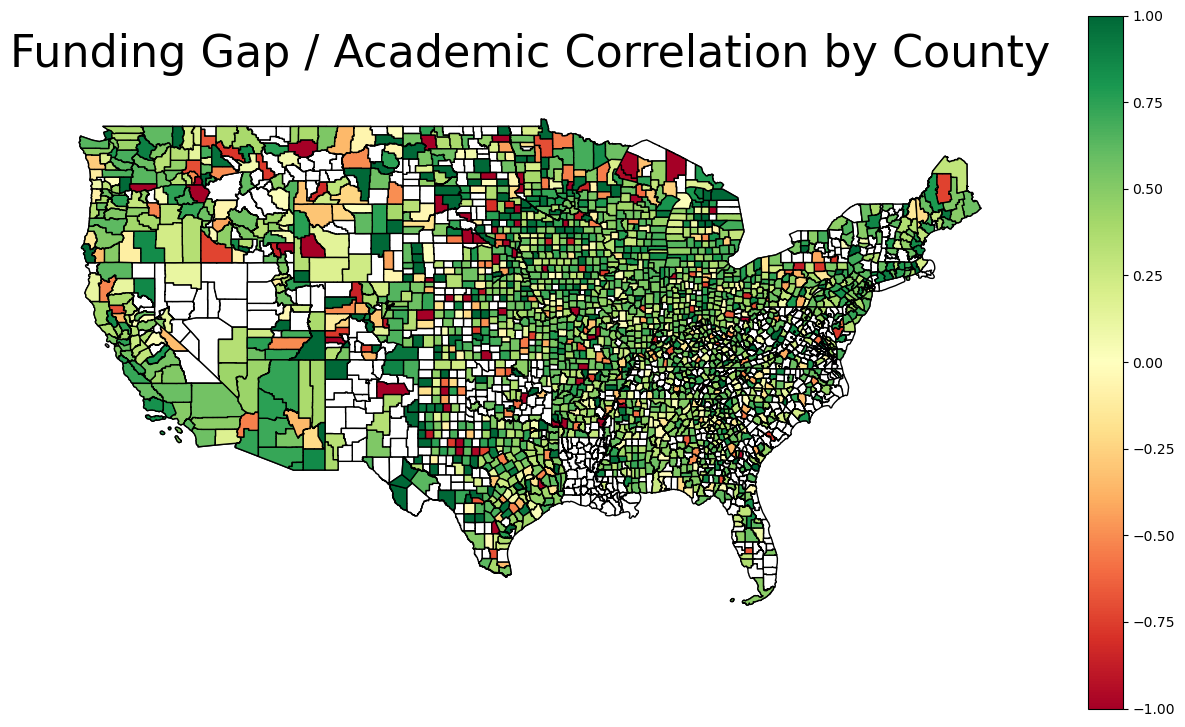

In [273]:
fig, gax = plt.subplots(figsize = (16,9))

# Plot the state
county_shape19.plot(ax = gax, edgecolor='black',color='white')
combined19.plot(ax = gax, edgecolor='black', column='Correlation', legend=True, cmap='RdYlGn', vmin = -1, vmax=1)

# I don't want the axis with long and lat
plt.axis('off')

gax.set_title('Funding Gap / Academic Correlation by County', fontsize=32, color='black', pad=20)

plt.show()

The data above shows the correlation between the relative amount of money a school spends on its students as compared to the median family income in an area. For ease of sight, this map groups the data by county. As might be expected, for most counties, the higher the median income of a family is in a particular area, the more money the schools spend per student. There  are numerous counties, especially in the North and the Prairies, where that correlation isn't as fixed, but for the most part there is a moderate to strong positive correlation between personal income and school spending on students. Those areas with less strong positive correlations also tend to be less developed, indicating a potential effect of external public support, which was hinted at on with Title I funding. One thing to note, though, is that there is a lot of county data missing for Nevada, Lousiana, and New Mexico,  which opens up small gaps in the research. Still, the data is mostly complete so that the insights gained here are still relatively meaningful.

## Regressions
Here's some table that has regressions

In [279]:
import statsmodels.api as sm

df19['const'] = 1
df19['is_charter'] = (df19['CHARTER_TEXT'] != 'No').astype(int)

reg0 = sm.OLS(endog=df19['outcomegap'], exog=df19[['const', 'white_%']],
             missing = 'drop')
results0 = reg0.fit()

reg1 = sm.OLS(endog=df19['outcomegap'], exog=df19[['const', 'white_%', 'family_income']],
             missing = 'drop')
results1 = reg1.fit()

reg2 = sm.OLS(endog=df19['outcomegap'], exog=df19[['const', 'fundinggap', 'family_income']],
             missing = 'drop')
results2 = reg2.fit()

reg3 = sm.OLS(endog=df19['white_%'], exog=df19[['const', 'TOTFRL', 'ell']],
             missing = 'drop')
results3 = reg3.fit()

reg4 = sm.OLS(endog=df19['family_income'], exog=df19[['const', 'white_%', 'ell']],
             missing = 'drop')
results4 = reg4.fit()

reg5 = sm.OLS(endog=df19['TOTFRL'], exog=df19[['const', 'family_income', 'fundinggap']],
             missing = 'drop')
results5 = reg5.fit()


In [281]:
print(results1.summary())
print(results2.summary())
print(results3.summary())
print(results4.summary())
print(results5.summary())

                            OLS Regression Results                            
Dep. Variable:             outcomegap   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                 2.547e+04
Date:                Sat, 15 Mar 2025   Prob (F-statistic):               0.00
Time:                        18:48:17   Log-Likelihood:                -6554.0
No. Observations:               67401   AIC:                         1.311e+04
Df Residuals:                   67398   BIC:                         1.314e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.6665      0.003   -217.422

## Conclusion + Next Steps

There are a couple interesting insights to recall. Notably, we find that the Title I aid program seems to rightfully target areas where there are more low income households. We find that there is a potentially nonlinear relationship between the required student funding and academic achievement...
As time goes on, I intend to also analyze data from the 2021-22 school year to see if COVID-19 may have impacted these trends. I also intend to look for more informative and specific data sources to gain more meaningful insights, as well as integrate other tools from the course for more meaningful analysis.

### Citations
All citations are in APA style.

Main Paper:

Dixon-RomÁN, E. J., Everson, H. T., & Mcardle, J. J. (2013). Race, poverty and SAT scores: Modeling the influences of family income on black and white high school students’ sat performance. Teachers College Record: The Voice of Scholarship in Education, 115(4), 1–33. https://doi.org/10.1177/016146811311500406 

Other Papers:

1. Farkas, G. (2004). The black-white test score gap. Contexts, 3(2), 12–19. https://doi.org/10.1525/ctx.2004.3.2.12 

2. Paterson, M., Parasnis, J., & Rendall, M. (2024). Gender, socioeconomic status, and numeracy test scores. Journal of Economic Behavior &amp; Organization, 227, 106751. https://doi.org/10.1016/j.jebo.2024.106751 

3. Osborne, J. W. (1997). Race and academic disidentification. Journal of Educational Psychology, 89(4), 728–735. https://doi.org/10.1037//0022-0663.89.4.728 

4. Prudence L. Carter. (2016). Educational Equality Is a Multifaceted Issue: Why We Must Understand the School’s Sociocultural Context for Student Achievement. RSF: The Russell Sage Foundation Journal of the Social Sciences, 2(5), 142–163. https://doi.org/10.7758/rsf.2016.2.5.07

5. Wodtke, G. T., Yildirim, U., Harding, D. J., & Elwert, F. (2023). Are neighborhood effects explained by differences in school quality? American Journal of Sociology, 128(5), 1472–1528. https://doi.org/10.1086/724279
